# 语言模型和数据集

在**文本序列预处理中**中，我们了解了如何将文本数据映射为词元，以及将这些词元可以视为一系列离散的观测。

例如单词或字符。
假设长度为$T$的文本序列中的词元依次为$x_1, x_2, \ldots, x_T$。
于是，$x_t$（$1 \leq t \leq T$）
可以被认为是文本序列在时间步$t$处的观测或标签。
在给定这样的文本序列时，*语言模型*（language model）的**目标是估计序列的联合概率**
$$P(x_1, x_2, \ldots, x_T).$$

例如，只需要一次抽取一个词元$x_t \sim P(x_t \mid x_{t-1}, \ldots, x_1)$，
一个理想的语言模型就能够基于模型本身生成自然文本。
与猴子使用打字机完全不同的是，从这样的模型中提取的文本
都将作为自然语言（例如，英语文本）来传递。
只需要基于前面的对话片断中的文本，
就足以生成一个有意义的对话。
显然，我们离设计出这样的系统还很遥远，
因为它需要“理解”文本，而不仅仅是生成语法合理的内容。

尽管如此，语言模型依然是非常有用的。
例如，短语“to recognize speech”和“to wreck a nice beach”读音上听起来非常相似。
这种相似性会导致语音识别中的歧义，但是这很容易通过语言模型来解决，
因为第二句的语义很奇怪。
同样，在文档摘要生成算法中，
“狗咬人”比“人咬狗”出现的频率要高得多，
或者“我想吃奶奶”是一个相当匪夷所思的语句，
而“我想吃，奶奶”则要正常得多。

## 马尔可夫模型与$n$元语法

在讨论包含深度学习的解决方案之前，我们需要了解更多的概念和术语。
回想一下我们在 :numref:`sec_sequence`中对马尔可夫模型的讨论，
并且将其应用于语言建模。
如果$P(x_{t+1} \mid x_t, \ldots, x_1) = P(x_{t+1} \mid x_t)$，
则序列上的分布满足一阶马尔可夫性质。
阶数越高，对应的依赖关系就越长。
这种性质推导出了许多可以应用于序列建模的近似公式：

$$
\begin{aligned}
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2) P(x_3) P(x_4),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_2) P(x_4  \mid  x_3),\\
P(x_1, x_2, x_3, x_4) &=  P(x_1) P(x_2  \mid  x_1) P(x_3  \mid  x_1, x_2) P(x_4  \mid  x_2, x_3).
\end{aligned}
$$

通常，涉及一个、两个和三个变量的概率公式分别被称为
“一元语法”（unigram）、“二元语法”（bigram）和“三元语法”（trigram）模型。

<img src="pic\5.jpg" width=500/>

<img src="pic\6.jpg" width=500/>

下面，我们将学习如何去设计更好的模型。

## 自然语言统计

我们看看在真实数据上如果进行自然语言统计。
根据 :numref:`sec_text_preprocessing`中介绍的时光机器数据集构建词表，
并打印前$10$个最常用的（频率最高的）单词。


In [1]:
import torch 
import random
from d2l import torch as d2l
import re
from itertools import count
import collections

## 读取数据集
首先，我们从H.G.Well的[时光机器](https://www.gutenberg.org/ebooks/35)中加载文本。
这是一个相当小的语料库，只有30000多个单词，但足够我们小试牛刀，
而现实中的文档集合可能会包含数十亿个单词。
下面的函数(**将数据集读取到由多条文本行组成的列表中**)，其中每条文本行都是一个字符串。
为简单起见，我们在这里忽略了标点符号和字母大写。

In [2]:
#@save下载数据集
#d2l.DATA_HUB['time_machine'] = (d2l.DATA_URL + 'timemachine.txt',
#                                '090b5e7e70c295757f55df93cb0a180b9691891a')
def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open("data\\timemachine.txt", 'r') as f:
        lines = f.readlines()
    #对文本进行分词处理
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]  
#词元话
def tokenize(lines,token="word"):
    '''将文本行拆分为单词或字符词源'''
    if token=="word":
        return [line.split() for line in lines]
    elif token=="char":
        return [list(line) for line in lines]
    else:
        print("错误，未知词源类型,"+token)
lines= read_time_machine()
tokens=tokenize(lines)
#因为每个文本行不一定是一个句子或一个段落，因此我们把所有文本行拼接到一起
corpus=[token for line in tokens for token in line]
#构建词表
class Vocab():
    '''文本词汇表
    min_freq：如果一个词出现的频率<min_freq，则放入不认识的token中
    reserved_tokens：句子的开头token，或者结尾token
    '''
    def __init__(self,tokens=None,min_freq=0,reserved_tokens=None):
        #如果没有token则为空列表
        if tokens is None:
            tokens=[]
        if reserved_tokens is None:
            reserved_tokens=[]
        counter=count_corpus(tokens)  #计算每个token出现的次数（词频统计）
        #对词典更具词频进行降序排序，返回token和freq（词频数）,
        self.token_freqs=sorted(counter.items(),key=lambda x:x[1],reverse=True)
        #unk：位置的token  uniq_tokens：定义token是开头或结尾   
        self.unk,uniq_tokens=0,["<unk>"]+reserved_tokens
        #只存储词，舍去freq<min_freq的词，并且不是位置词汇
        uniq_tokens+=[token for token,freq in self.token_freqs
                    if freq >=min_freq and token not in uniq_tokens]
        #给你索引转为token保存在列表中，给你token转为索引（不是词频）保存在字典中
        self.idx_to_token,self.token_to_idx=[],dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token]=len(self.idx_to_token)-1

    #一共有多少个token  
    def __len__(self):
        return len(self.idx_to_token)
    #给你token返回index
    def __getitem__(self,tokens):
        #判断
        if not isinstance(tokens,(list,tuple)):
            return self.token_to_idx.get(tokens,self.unk)
        return [self.__getitem__(token) for token in tokens]
    #给你index，返回token
    def to_tokens(self,indices):
        if not isinstance(indices,(list,tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

vocab = Vocab(corpus)
vocab.token_freqs[:10]  #词频数

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

正如我们所看到的，(**最流行的词**)看起来很无聊，
这些词通常(**被称为*停用词***)（stop words），因此可以被过滤掉。
尽管如此，它们本身仍然是有意义的，我们仍然会在模型中使用它们。

此外，还有个明显的问题是词频衰减的速度相当地快。
例如，最常用单词的词频对比，第$10$个还不到第$1$个的$1/5$。
为了更好地理解，我们可以[**画出的词频图**]：

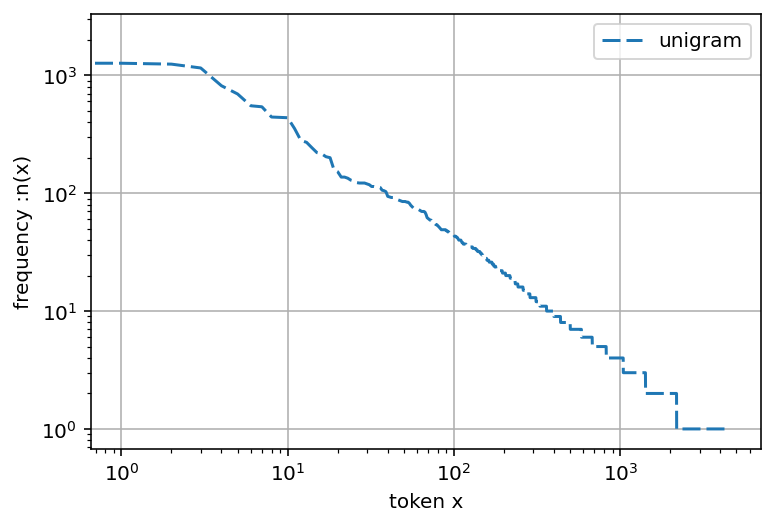

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'  #高清图像

freqs=[freq for token,freq in vocab.token_freqs]  #词频数
#可视化
fig,ax=plt.subplots()  #创建窗口
plt.grid()  #添加网格
ax.loglog(freqs,dashes=[6, 2],label="unigram")
plt.xlabel("token x")
plt.ylabel("frequency :n(x)")
plt.legend()

通过此图我们可以发现：词频以一种明确的方式迅速衰减。
将前几个单词作为例外消除后，剩余的所有单词大致遵循双对数坐标图上的一条直线。
这意味着单词的频率满足*齐普夫定律*（Zipf's law），
即第$i$个最常用单词的频率$n_i$为：

$$n_i \propto \frac{1}{i^\alpha},$$
:eqlabel:`eq_zipf_law`

等价于

$$\log n_i = -\alpha \log i + c,$$

其中$\alpha$是刻画分布的指数，$c$是常数。
这告诉我们想要通过计数统计和平滑来建模单词是不可行的，
因为这样建模的结果会大大高估尾部单词的频率，也就是所谓的不常用单词。
那么[**其他的词元组合，比如二元语法、三元语法等等，又会如何呢？**]
我们来看看二元语法的频率是否与一元语法的频率表现出相同的行为方式。

In [4]:
#二元语法
bigram_tokens = [pair for pair in zip(corpus[:-1], corpus[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[(('of', 'the'), 309),
 (('in', 'the'), 169),
 (('i', 'had'), 130),
 (('i', 'was'), 112),
 (('and', 'the'), 109),
 (('the', 'time'), 102),
 (('it', 'was'), 99),
 (('to', 'the'), 85),
 (('as', 'i'), 78),
 (('of', 'a'), 73)]

这里值得注意：在十个最频繁的词对中，有九个是由两个停用词组成的，
只有一个与“the time”有关。
我们再进一步看看三元语法的频率是否表现出相同的行为方式。

In [5]:
#三元语法
trigram_tokens = [pair for pair in zip(corpus[:-2],corpus[1:-1],corpus[2:])]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[(('the', 'time', 'traveller'), 59),
 (('the', 'time', 'machine'), 30),
 (('the', 'medical', 'man'), 24),
 (('it', 'seemed', 'to'), 16),
 (('it', 'was', 'a'), 15),
 (('here', 'and', 'there'), 15),
 (('seemed', 'to', 'me'), 14),
 (('i', 'did', 'not'), 14),
 (('i', 'saw', 'the'), 13),
 (('i', 'began', 'to'), 13)]

最后，我们[**直观地对比三种模型中的词元频率**]：一元语法、二元语法和三元语法。

4579 20234 29882


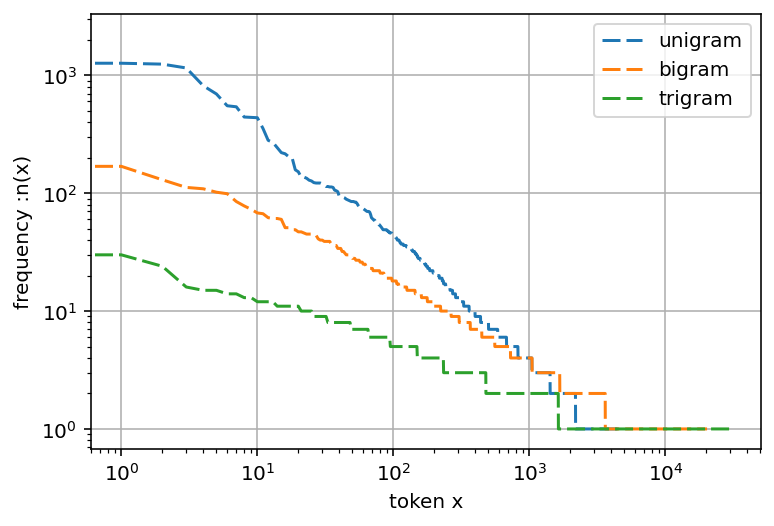

In [6]:
bigram_freqs=[freq for token,freq in bigram_vocab.token_freqs]
trigram_freqs=[freq for token,freq in trigram_vocab.token_freqs]
print(len(freqs),len(bigram_freqs),len(trigram_freqs))
#可视化
fig,ax=plt.subplots()  #创建窗口
plt.grid()  #添加网格
ax.loglog(freqs,dashes=[6, 2],label="unigram")
ax.loglog(bigram_freqs,dashes=[6, 2],label="bigram")
ax.loglog(trigram_freqs,dashes=[6, 2],label="trigram")
plt.xlabel("token x")
plt.ylabel("frequency :n(x)")
plt.legend()

这张图非常令人振奋！原因有很多：
首先，除了一元语法词，单词序列似乎也遵循齐普夫定律，
尽管公式 :eqref:`eq_zipf_law`中的指数$\alpha$更小
（指数的大小受序列长度的影响）。
其次，词表中$n$元组的数量并没有那么大，这说明语言中存在相当多的结构，
这些结构给了我们应用模型的希望。
第三，很多$n$元组很少出现，这使得拉普拉斯平滑非常不适合语言建模。
作为代替，我们将使用基于深度学习的模型。

## 读取长序列数据

由于序列数据本质上是连续的，因此我们在处理数据时需要解决这个问题。

在 :numref:`sec_sequence`中我们以一种相当特别的方式做到了这一点：
当序列变得太长而不能被模型一次性全部处理时，
我们可能希望拆分这样的序列方便模型读取。

在介绍该模型之前，我们看一下总体策略。
假设我们将使用神经网络来训练语言模型，
模型中的网络一次处理具有预定义长度
（例如$n$个时间步）的一个小批量序列。
现在的问题是如何[**随机生成一个小批量数据的特征和标签以供读取。**]

首先，由于文本序列可以是任意长的，
例如整本《时光机器》（*The Time Machine*），
于是任意长的序列可以被我们划分为具有相同时间步数的子序列。
当训练我们的神经网络时，这样的小批量子序列将被输入到模型中。
假设网络一次只处理具有$n$个时间步的子序列。
 :numref:`fig_timemachine_5gram`画出了
从原始文本序列获得子序列的所有不同的方式，
其中$n=5$，并且每个时间步的词元对应于一个字符。
请注意，因为我们可以选择任意偏移量来指示初始位置，所以我们有相当大的自由度。

![分割文本时，不同的偏移量会导致不同的子序列]

<img src="pic\7.jpg" width=500/>

:label:`fig_timemachine_5gram`

因此，我们应该从 :numref:`fig_timemachine_5gram`中选择哪一个呢？
事实上，他们都一样的好。
然而，如果我们只选择一个偏移量，
那么用于训练网络的、所有可能的子序列的覆盖范围将是有限的。
因此，我们可以从随机偏移量开始划分序列，
以同时获得*覆盖性*（coverage）和*随机性*（randomness）。
下面，我们将描述如何实现*随机采样*（random sampling）和
*顺序分区*（sequential partitioning）策略。

## 随机采样
    自然语言数据可以看成一种特殊的时间序列数据。对于这种时序数据的采样主要有有随机采样和相邻采样两种方式。两者都需要确定一个batch的样本数量batch_size和每个样本的时间步长num_steps。

步骤：语料库corpus_indices的长度为n，首先按照时间步长确定可能的样本的起始索引，可能的样本起始索引最后被随机打散。

这里注意：采样的单个样本的最后一个单词不可能是序列的最后一个字（否则，就没有输入子序列所对应的输出子序列）

如图所示：对于一个长度为32序列0,1,2,…,31，时间步长取4，batch大小取3时，有效长度只有28。
<img src="pic\8.png" width=600/>

下面的代码每次可以从数据中随机生成一个小批量。 在这里，参数batch_size指定了每个小批量中子序列样本的数目， 参数num_steps是每个子序列中预定义的时间步数。

In [7]:
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    #corpus = corpus[random.randint(0, num_steps - 1):]
    
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps  #一共可以生成多少子序列
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)
    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size   #batche的个数

    for i in range(0,num_batches*batch_size, batch_size):
        # 每次选出batch_size个随机样本
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        x = [data(j) for j in initial_indices_per_batch]    #序列
        y = [data(j + 1) for j in initial_indices_per_batch]  #二元语法
        yield torch.tensor(x), torch.tensor(y)

下面我们[**生成一个从$0$到$34$的序列**]。
假设批量大小为$2$，时间步数为$5$，这意味着可以生成
$\lfloor (35 - 1) / 5 \rfloor= 6$个“特征－标签”子序列对。
如果设置小批量大小为$2$，我们只能得到$3$个小批量。

In [8]:
my_seq = list(range(35))
for X, Y in seq_data_iter_random(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 0,  1,  2,  3,  4],
        [25, 26, 27, 28, 29]]) 
Y: tensor([[ 1,  2,  3,  4,  5],
        [26, 27, 28, 29, 30]])
X:  tensor([[15, 16, 17, 18, 19],
        [20, 21, 22, 23, 24]]) 
Y: tensor([[16, 17, 18, 19, 20],
        [21, 22, 23, 24, 25]])
X:  tensor([[10, 11, 12, 13, 14],
        [ 5,  6,  7,  8,  9]]) 
Y: tensor([[11, 12, 13, 14, 15],
        [ 6,  7,  8,  9, 10]])


x表示序列，y表示预测的标签。

例如，x的15预测y的16；x的15,16预测y的17；x的15,16,17预测y的18；一次类推。

## 相邻采样
在相邻采样中，相邻的两个随机小批量在原始序列上的位置相毗邻。

先确定待采样的有效序列的长度，在按照batch_size对该有效序列进行均分，然后按照时间步长num_step对堆叠的子序列进行逐个采样。

In [9]:
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        x = Xs[:, i: i + num_steps]
        y = Ys[:, i: i + num_steps]
        yield x, y

In [10]:
for X, Y in seq_data_iter_sequential(my_seq, batch_size=2, num_steps=5):
    print('X: ', X, '\nY:', Y)

X:  tensor([[ 4,  5,  6,  7,  8],
        [19, 20, 21, 22, 23]]) 
Y: tensor([[ 5,  6,  7,  8,  9],
        [20, 21, 22, 23, 24]])
X:  tensor([[ 9, 10, 11, 12, 13],
        [24, 25, 26, 27, 28]]) 
Y: tensor([[10, 11, 12, 13, 14],
        [25, 26, 27, 28, 29]])
X:  tensor([[14, 15, 16, 17, 18],
        [29, 30, 31, 32, 33]]) 
Y: tensor([[15, 16, 17, 18, 19],
        [30, 31, 32, 33, 34]])


现在，我们[**将上面的两个采样函数包装到一个类中**]，
以便稍后可以将其用作数据迭代器。


In [11]:
#读取数据集
def read_time_machine():  #@save
    """将时间机器数据集加载到文本行的列表中"""
    with open("data\\timemachine.txt", 'r') as f:
        lines = f.readlines()
    #对文本进行分词处理
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]
#词元划分
def tokenize(lines,token="word"):
    '''将文本行拆分为单词或字符词源'''
    if token=="word":
        return [line.split() for line in lines]
    elif token=="char":
        return [list(line) for line in lines]
    else:
        print("错误，未知词源类型,"+token)
#生成文本词汇表
class Vocab():
    '''文本词汇表
    min_freq：如果一个词出现的频率<min_freq，则放入不认识的token中
    reserved_tokens：句子的开头token，或者结尾token
    '''
    def __init__(self,tokens=None,min_freq=0,reserved_tokens=None):
        #如果没有token则为空列表
        if tokens is None:
            tokens=[]
        if reserved_tokens is None:
            reserved_tokens=[]
        counter=count_corpus(tokens)  #计算每个token出现的次数（词频统计）
        #对词典更具词频进行排序，返回token和freq（词频数）
        self.token_freqs=sorted(counter.items(),key=lambda x:x[1],reverse=True)
        #unk：位置的token  uniq_tokens：定义token是开头或结尾   
        self.unk,uniq_tokens=0,["<unk>"]+reserved_tokens
        #只存储词，舍去freq<min_freq的词，并且不是位置词汇
        uniq_tokens+=[token for token,freq in self.token_freqs
                    if freq >=min_freq and token not in uniq_tokens]
        #给你索引转为token保存在列表中，给你token转为索引（不是词频）保存在字典中
        self.idx_to_token,self.token_to_idx=[],dict()
        for token in uniq_tokens:
            self.idx_to_token.append(token)
            self.token_to_idx[token]=len(self.idx_to_token)-1

    #一共有多少个token  
    def __len__(self):
        return len(self.idx_to_token)
    #给你token返回index
    def __getitem__(self,tokens):
        #判断
        if not isinstance(tokens,(list,tuple)):
            return self.token_to_idx.get(tokens,self.unk)
        return [self.__getitem__(token) for token in tokens]
    #给你index，返回token
    def to_tokens(self,indices):
        if not isinstance(indices,(list,tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]
#统计词源频率       
def count_corpus(tokens):  #@save
    """统计词元的频率"""
    # 这里的tokens是1D列表或2D列表
    if len(tokens) == 0 or isinstance(tokens[0], list):
        # 将词元列表展平成一个列表
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)
#词元索引列表和词表
def load_corpus_time_machine(max_tokens=-1):  #@save
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines, 'char')
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]  #返回索引
    #如果数据太大，限制大小，加快训练速度
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab
#随机抽样
def seq_data_iter_random(corpus, batch_size, num_steps):  #@save
    """使用随机抽样生成一个小批量子序列"""
    # 从随机偏移量开始对序列进行分区，随机范围包括num_steps-1
    #corpus = corpus[random.randint(0, num_steps - 1):]
    
    # 减去1，是因为我们需要考虑标签
    num_subseqs = (len(corpus) - 1) // num_steps  #一共可以生成多少子序列
    # 长度为num_steps的子序列的起始索引
    initial_indices = list(range(0, num_subseqs * num_steps, num_steps))
    # 在随机抽样的迭代过程中，
    # 来自两个相邻的、随机的、小批量中的子序列不一定在原始序列上相邻
    random.shuffle(initial_indices)
    def data(pos):
        # 返回从pos位置开始的长度为num_steps的序列
        return corpus[pos: pos + num_steps]

    num_batches = num_subseqs // batch_size   #batche的个数

    for i in range(0,num_batches*batch_size, batch_size):
        # 每次选出batch_size个随机样本
        initial_indices_per_batch = initial_indices[i: i + batch_size]
        x = [data(j) for j in initial_indices_per_batch]    #序列
        y = [data(j + 1) for j in initial_indices_per_batch]  #二元语法
        yield torch.tensor(x), torch.tensor(y)
#相邻抽样
def seq_data_iter_sequential(corpus, batch_size, num_steps):  #@save
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        x = Xs[:, i: i + num_steps]
        y = Ys[:, i: i + num_steps]
        yield x, y 
#加载数据迭代器
class SeqDataLoader:  #@save
    """加载序列数据的迭代器
    max_tokens：如果数据集太大，截断数据集，加快训练
    """
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        #如果是随机采样
        if use_random_iter:
            self.data_iter_fn = seq_data_iter_random
        #相邻采样
        else:
            self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab =load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        #将数据传入
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

[**最后，我们定义了一个函数`load_data_time_machine`，
它同时返回数据迭代器和词表**]，
因此可以与其他带有`load_data`前缀的函数
（如 :numref:`sec_fashion_mnist`中定义的
`d2l.load_data_fashion_mnist`）类似地使用。


In [12]:
#迭代器和词表
def load_data_time_machine(batch_size, num_steps,  #@save
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab

In [14]:
data_iter,data_iter_vocab=load_data_time_machine(batch_size=3, num_steps=5,  #@save
                    use_random_iter=False, max_tokens=10000)
for x in data_iter_vocab:
    print(x)

## 小结

* 语言模型是自然语言处理的关键。
* $n$元语法通过截断相关性，为处理长序列提供了一种实用的模型。
* 长序列存在一个问题：它们很少出现或者从不出现。
* 齐普夫定律支配着单词的分布，这个分布不仅适用于一元语法，还适用于其他$n$元语法。
* 通过拉普拉斯平滑法可以有效地处理结构丰富而频率不足的低频词词组。
* 读取长序列的主要方式是随机采样和顺序分区。在迭代过程中，后者可以保证来自两个相邻的小批量中的子序列在原始序列上也是相邻的。